### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

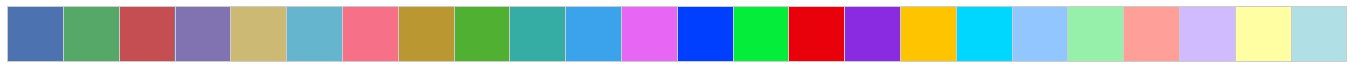

In [111]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
import warnings
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import (
    add_mse, add_normed_err, err_cols, add_errs, create_distr, get_dll_pdf, get_dll_cdf, ez,
    add_velocity, vm_cols
)

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [52]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + foi_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 5.02 s


In [97]:
%%time
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
global_foi_train_data = pd.read_pickle(closest_hits_filename).loc[:, xyz_cols + t_cols + dxyz_cols].copy()
global_foi_train_data.columns = cl_cols
print(global_foi_train_data.columns)

Index(['Cl_MatchedHit_X[0]', 'Cl_MatchedHit_X[1]', 'Cl_MatchedHit_X[2]',
       'Cl_MatchedHit_X[3]', 'Cl_MatchedHit_Y[0]', 'Cl_MatchedHit_Y[1]',
       'Cl_MatchedHit_Y[2]', 'Cl_MatchedHit_Y[3]', 'Cl_MatchedHit_Z[0]',
       'Cl_MatchedHit_Z[1]', 'Cl_MatchedHit_Z[2]', 'Cl_MatchedHit_Z[3]',
       'Cl_MatchedHit_T[0]', 'Cl_MatchedHit_T[1]', 'Cl_MatchedHit_T[2]',
       'Cl_MatchedHit_T[3]', 'Cl_MatchedHit_DX[0]', 'Cl_MatchedHit_DX[1]',
       'Cl_MatchedHit_DX[2]', 'Cl_MatchedHit_DX[3]', 'Cl_MatchedHit_DY[0]',
       'Cl_MatchedHit_DY[1]', 'Cl_MatchedHit_DY[2]', 'Cl_MatchedHit_DY[3]',
       'Cl_MatchedHit_DZ[0]', 'Cl_MatchedHit_DZ[1]', 'Cl_MatchedHit_DZ[2]',
       'Cl_MatchedHit_DZ[3]'],
      dtype='object')
Wall time: 2.94 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [53]:
# готовим данные для распределения DLL

# либо загружаем уже готовое
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
# dll_train = pd.read_pickle(closest_hits_filename)
# display(dll_train.columns)

# либо считаем заново
dll_train, _ = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)
dll_train = add_mse(dll_train, [])

# опционально пересчитываем MatchedHits и заменяем ими координаты треков в dll_train, чтобы считать распределение на пересчитанных треках
# dll_train = replace_hits(dll_train, [])

# save DLL
# display(dll_train.columns)
# dll_train.to_pickle(closest_hits_filename)

In [54]:
# если распределение для DLL уже есть сохраненное, то загружаем
# cdfs, pdfs, bins = np.load('data/train_cdfs.pkl.npy'), np.load('data/train_pdfs.pkl.npy'), np.load('data/train_bins.pkl.npy')

# либо считаем на основе загруженного dll_train
cdfs, pdfs, bins = create_distr(dll_train)
# np.save('data/train_cdfs.pkl.npy', cdfs)
# np.save('data/train_pdfs.pkl.npy', pdfs)
# np.save('data/train_bins.pkl.npy', bins)

In [5]:
def add_dll(data, features):
    data[err_cols[1]] = get_dll_pdf(data.loc[:, err_cols[0]], pdfs, cdfs, bins)
    features += err_cols[1:2]
    return data

In [108]:
def fit(train, n_estimators, transformer_cls):
    labels, weights = get_labels_weights(train.loc[:, train_cols])

    # defined much later
    transformer = transformer_cls().fit(train)
    train_values = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=n_estimators, n_jobs=3)
    estimator.fit(train_values, labels, eval_metric=scoring.rejection90_sklearn, sample_weight=weights)
    return transformer, estimator


In [252]:
# здесь пока хуй пойми что :)

hc_preimage_cols = xyz_cols + t_cols + dxyz_cols
hc_image_cols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
seg_col = foi_ts_cols[2]
nrows = 2
train, train_foi = read_train(used_cols, nrows)

# по идее должен заполнять датафрейм ближайшими хитами
def fill_global_closest_matched_hits(data, data_foi):
#     data_foi.astype({seg_col: np.int8}, copy=False)
#     cur_foi_cols = foi_xyz_cols[:2] + foi_dxyz_cols[:2] + foi_ts_cols[:1] + foi_ts_cols[-2:]
#     data_foi = data_foi.loc[:, ['id'] + cur_foi_cols]
#     data_foi.set_index('id', inplace=True)
    
#     segs = [data_foi.loc[data_foi[seg_col] == i, :] for i in range(4)]
#     dt = segs[0].copy()
#     for i in range(1, 4):
#         dt = dt.merge(segs[i], how='outer', left_index=True, right_index=True, suffixes=('', '%d' % i))
    
#     dt.columns = [
#         cur_foi_cols[i] + ('[%d]' % j)
#         for j in range(4)
#         for i in range(len(cur_foi_cols))
#     ]
#     print(data.shape, data_foi.shape, dt.shape)
#     print((data_foi.index == 0).sum(), (dt.index == 0).sum())
    display(data_foi)
#     display(dt.head(10))
    
#     data_foi.set_index(['id', seg_col], inplace=True)
    
#     join = data_foi.join(data.loc[:, exy_cols], how='right')
#     s0 = join.loc[(slice(None), 0), :]
#     s0 = s0.set_index(s0.index.droplevel(1))
#     s1 = join.loc[(slice(None), 1), :]
#     s1 = s1.set_index(s1.index.droplevel(1))
#     display(s0.join(s1, how='outer', lsuffix='_0', rsuffix='_1'))
#     display(s0.set_index(['id']).join(s1.set_index(['id']), how='inner', lsuffix='_0', rsuffix='_1'))
#     for i in range(4):
#         join.loc[(slice(None), i), :]
#         slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
#         dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
#         dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
#         join.loc[mask, 'D2'] = dx**2 + dy**2
        
#     res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
#     res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
#     subcols = hc_image_cols
#     nsubcols = len(subcols)
#     for i, col in enumerate(cl_cols):
#         mask = res[foi_ts_cols[2]] == (i % 4)
#         indices = res.loc[mask, 'id']
#         data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

global_foi_train_data = fill_global_closest_matched_hits(train, train_foi)
# df_scores, feature_importance = cross_validate(train, n_estimators=20, n_splits=3, n_rows=nrows, transformer_cls=DataTransformer)
# display(df_scores.describe())

,id,FOI_hits_X,FOI_hits_Y,FOI_hits_Z,FOI_hits_DX,FOI_hits_DY,FOI_hits_DZ,FOI_hits_T,FOI_hits_DT,FOI_hits_S
0,0,-2685.080078,1373.348145,15123.044922,25.5,126.278549,33.954948,3.0,0.0,0.0
1,0,-2583.080078,1373.348145,15123.044922,25.5,126.278549,33.954948,11.0,8.0,0.0
2,0,-2954.300049,1481.262207,16327.632812,27.5,136.278488,33.990959,2.0,0.0,1.0
3,0,-3376.969971,1590.397461,17520.826172,118.0,146.278412,34.026966,7.0,0.0,2.0
4,0,-3140.969971,1590.397461,17520.826172,118.0,146.278412,34.026966,7.0,0.0,2.0
5,0,-3609.169922,1701.067627,18729.324219,126.0,156.278351,34.062977,5.0,0.0,3.0


In [ ]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.01]
    return features

def replace_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col[3:]] = global_foi_data.loc[data.index.values, col].values
    return data

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + dxyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

#         data = replace_hits(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        add_velocity(data, features)
#         add_cl_hits(data, features)
#         add_cl_mse(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

### Test theory

In [223]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788910,0.783485,0.880341,0.829087,0.821262,0.762616,0.086423
std,0.002809,0.003721,0.002243,0.001863,0.004923,0.026157,0.002482
min,0.785350,0.779266,0.877053,0.826679,0.817333,0.743503,0.082020
25%,0.786461,0.779865,0.879718,0.827664,0.817455,0.744935,0.087119
50%,0.790290,0.784465,0.880234,0.829484,0.818337,0.746772,0.087391
75%,0.790860,0.786811,0.881706,0.830789,0.825683,0.774399,0.087600
max,0.791590,0.787016,0.882995,0.830819,0.827501,0.803469,0.087986


Wall time: 2min 36s


In [227]:
global_feature_importance = feature_importance.copy()
sum(global_feature_importance.score > .01)

25

In [228]:
display(global_feature_importance)

,score
ErrMSE,0.122619
PT,0.076190
NShared,0.052381
DAngle[2],0.047619
DAngle[1],0.042857
NErr_Y[3],0.040476
MT,0.032143
ncl[2],0.032143
ncl[0],0.030952
ncl[1],0.028571


### Get result

In [109]:
test, test_foi = read_pub_test(used_cols)
global_foi_test_data = fill_global_closest_matched_hits(test.copy(), test_foi)

In [226]:
%%time
_t = global_feature_importance
global_feature_importance = None
fit_predict_save(sample(train, 100000), test, "out/09_vm_100.csv", n_estimators=120, transformer_cls=DataTransformer)
global_feature_importance = _t

Wall time: 59.2 s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols

In [99]:
def to_closest_cols(cols):
    return ['Cl_' + col for col in cols]

cl_xyz_cols = to_closest_cols(xyz_cols)
cl_t_cols = to_closest_cols(t_cols)
cl_dxyz_cols = to_closest_cols(dxyz_cols)
cl_cols = cl_xyz_cols + cl_t_cols + cl_dxyz_cols

def fill_global_closest_matched_hits(data, data_foi):
    data.loc[:, 'id'] = data.index.values
    exy = data.loc[:, exy_cols]
    data_foi = data_foi.astype({foi_ts_cols[2]: np.int16})
    join = data_foi.join(exy, on='id', how='inner')
    for i in range(4):
        mask = join[foi_ts_cols[2]] == i
        slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
        dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
        dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
        join.loc[mask, 'D2'] = dx**2 + dy**2
        
    res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
    res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
    subcols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
    nsubcols = len(subcols)
    for i, col in enumerate(cl_cols):
        mask = res[foi_ts_cols[2]] == (i % 4)
        indices = res.loc[mask, 'id']
        data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

def add_cl_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col] = global_foi_data.loc[data.index.values, col].values        
    features += cl_cols
    return data

def add_cl_mse(data, features):
    dxy = (data.loc[:, cl_xyz_cols[:8]].values - data.loc[:, exy_cols].values) / data.loc[:, cl_dxyz_cols[:8]].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    col = 'cl_' + err_cols[0]
    data.loc[:, col] = D
    features += [col]
    return data

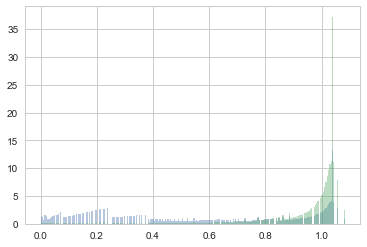

In [133]:
def plot_dll(data):
    DLL = get_dll_cdf(data, pdfs, cdfs, bins)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, bins=len(bins), kde=False, norm_hist=True)

dts = [dt.loc[:, err_cols[0]] for dt in split_classes(dll_train)]
plot_dll(dts[0].values)
plot_dll(dts[1].values)
# plot_dll(dll_train.loc[:, err_cols[0]].values)